(robust_cvar_portfolio:title)=
# Conditional Value-at-Risk in Robust Portfolio

## Problem and Data Description
The robust portfolio management model proposed by {cite:ps}`Zhu_Fukushima2009worst` minimizes the conditional value-at-risk (CVaR) under the worst-case distributions over an uncertainty set $\Pi$. The formulation is written as

$$
\begin{align}
\min~&\max\limits_{\pmb{\pi}\in\Pi}~\alpha + \frac{1}{1-\beta}\pmb{\pi}^{\top}\pmb{u} \\
\text{s.t.}~&u_k \geq -\pmb{y}_k^{\top}\pmb{x} - \alpha &&\forall k=1, 2, ..., s \\
&u_k \geq 0 &&\forall k=1, 2, ..., s \\
&\sum\limits_{k=1}^s\pi_k\pmb{r}_k^{\top}\pmb{x} \geq \mu&&\forall \pmb{\pi} \in \Pi \\
&\sum\limits_{i=1}^nx_i = 1, \\
&\pmb{x}\in\mathbb{R}_+^n, ~\pmb{u}\in\mathbb{R}^s, ~\alpha\in\mathbb{R}
\end{align}
$$

with investment decisions $\pmb{x}\in\mathbb{R}^n$ and auxiliary variables $\pmb{u}\in\mathbb{R}^s$ and $\alpha\in\mathbb{R}$ used for calculating the CVaR, assuming a confidence level of $\beta=0.95$, where $n$ is the number of stocks, and $s$ is the number of sample records. The array $\pmb{\pi}\in\mathbb{R}^S$ constitutes a vector of random variables representing sample probabilities. The worst-case minimum expected return rate of the portfolio is fixed at $\mu=0.0025$. 

In [1]:
beta = 0.95
mu = 0.0025

The parameter $\pmb{r}_k\in\mathbb{R}^n$ denotes the stock return rates in the $k$th sample record, determined by executing the following code with he weekly price data provided in the file [stocks.csv](stocks.csv).

In [2]:
import pandas as pd

data = pd.read_csv('stocks.csv').set_index('Date')
data

,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
Date,,,,,,,,
2016-03-14,64.949173,180.019562,102.719170,126.234161,24.238022,47.876026,46.356270,22.215748
2016-03-21,64.552208,177.648163,102.065163,125.569939,24.180813,48.520458,46.039604,21.925604
2016-03-28,66.684425,181.812302,105.153030,127.913895,25.169373,49.737732,47.046474,22.498055
2016-04-04,67.439835,184.411819,105.931198,127.226768,24.865019,48.708424,47.005863,21.713879
2016-04-11,66.925095,184.012543,105.782211,128.868317,25.137335,49.809334,47.850330,22.078634
...,...,...,...,...,...,...,...,...
2021-02-15,72.940125,308.861115,198.451248,156.066315,127.806870,234.667755,165.299896,42.086960
2021-02-22,71.719475,304.100555,192.747543,154.757996,119.333656,226.823624,159.664795,41.340672
2021-03-01,73.546188,315.877991,195.090607,159.832321,119.491135,226.062317,155.651611,42.612125


In [3]:
r = data.pct_change().dropna().values
s, n = r.shape

Different specifications for the uncertainty set $\Pi$ of probability distributions are illustrated in the upcoming sections.

## Nominal CVaR model

In the nominal model, the evaluation of CVaR and expected returns assumes that the exact distribution of stock returns is precisely represented by the historical samples, without introducing any distributional ambiguity. In other words, the uncertainty set is defined as $\Pi={\pmb{\pi}^0}$, where the probability $pi_k^0=1/s$, with $k=1, 2, ..., s$. The Python code for implementing the nominal model is provided below.

In [4]:
from rsome import ro
from rsome import msk_solver as msk
import numpy as np

model = ro.Model()

pi = np.ones(s) / s

x = model.dvar(n)
u = model.dvar(s)
alpha = model.dvar()

model.min(alpha + 1/(1-beta) * (pi@u))
model.st(u >= -r@x - alpha)
model.st(u >= 0)
model.st(pi@r@x >= mu)
model.st(x.sum() == 1, x>= 0, alpha >= 0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0177s


After solving the model to optimality, we may retrieve the optimal solution and objective value in terms of the CVaR of returns. 

In [5]:
x_nom = x.get()
print(f'Objective value: {model.get()}')

Objective value: 0.05633510806870595


## Worst-Case CVaR Model with Box Uncertainty

Here, we consider a box uncertainty set for probabilities:

$$
\Pi = \left\{
\pmb{\pi}: \pmb{\pi} = \pmb{\pi}^0 + \pmb{\eta}, ~\pmb{1}^{\top}\pmb{\eta}=0,~\underline{\pmb{\eta}}\leq \pmb{\eta} \leq \overline{\pmb{\eta}}
\right\},
$$

where $\pmb{\pi}^0$ used in the nominal model is the center of the box. In the following numerical study, we assume that $-\underline{\pmb{\eta}}\leq \pmb{\eta} \leq \overline{\pmb{\eta}} = 0.0005$, and the Python code for solving such a model is shown below.

In [6]:
from rsome import ro
from rsome import msk_solver as msk

model = ro.Model()

eta_ub = 0.0005                 # upper bound of eta
eta_lb = -0.0005                # lower bound of eta

eta = model.rvar(s)             # eta as random variables
uset = (eta.sum() == 0,
        eta >= eta_lb,
        eta <= eta_ub)
pi = 1/s + eta                  # pi as inexact probabilities

x = model.dvar(n)
u = model.dvar(s)
alpha = model.dvar()

model.minmax(alpha + 1/(1-beta) * (pi@u), uset)
model.st(u >= -r@x - alpha)
model.st(u >= 0)
model.st(pi@r@x >= mu)
model.st(x.sum() == 1, x>= 0, alpha >= 0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0207s


In [7]:
x_box = x.get()
print(f'Objective value: {model.get()}')

Objective value: 0.05943115482748882


## Worst-Case CVaR Model with Ellipsoidal Uncertainty

Besides a box uncertainty set, $\Pi$ can be expressed as an ellipsoid centered at $\pmb{\pi}^0$:

$$
\Pi = \left\{
\pmb{\pi}: \pmb{\pi} = \pmb{\pi}^0 + \rho\pmb{\eta}, ~\pmb{1}^{\top}\pmb{\eta}=0,~\pmb{\pi}^0 + \rho\pmb{\eta} \geq 0, ~ \|\pmb{\eta}\| \leq 1
\right\},
$$

where the radius coefficient $\rho=0.002$ in the following numerical studies. 

In [8]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

model = ro.Model()

rho = 0.002

eta = model.rvar(s)
uset = (eta.sum() == 0, 1/s + rho*eta >= 0,
        rso.norm(eta) <= 1)
pi = 1/s + rho*eta

x = model.dvar(n)
u = model.dvar(s)
alpha = model.dvar()

model.minmax(alpha + 1/(1-beta) * (pi@u), uset)
model.st(u >= -r@x - alpha)
model.st(u >= 0)
model.st(pi@r@x >= mu)
model.st(x.sum() == 1, x>= 0, alpha >= 0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0210s


In [9]:
x_ellip = x.get()
print(f'Objective value: {model.get()}')

Objective value: 0.06107405767448711


## Worst-Case CVaR with  Kullback-Leibler Divergence

The distribution ambiguity can also be captured by the Kullback-Leibler divergence metrics, hence we have the following uncertainty set

$$
\Pi = \left\{
\pmb{\pi}: \pmb{\pi} \geq \pmb{0},~\pmb{1}^{\top}\pmb{\pi}=1,~\sum\limits_{k=1}^s\pi_k\log\left(\frac{\pi_k}{\pi_k^0}\right) \leq \epsilon
\right\},
$$

where the empirical probability $\pi_k^0=1/s$ as mentioned in the nominal model. Assume that the constant $\epsilon=0.005$, the code for implementing such a robust model can be written as below.

In [10]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

model = ro.Model()

epsilon = 0.005

pi = model.rvar(s)
uset = (pi.sum() ==1, pi >= 0,
        rso.kldiv(pi, 1/s, epsilon))    # uncertainty set of pi

x = model.dvar(n)
u = model.dvar(s)
alpha = model.dvar()

model.minmax(alpha + 1/(1-beta) * (pi@u), uset)
model.st(u >= -r@x - alpha)
model.st(u >= 0)
model.st(pi@r@x >= mu)
model.st(x.sum() == 1, x>= 0, alpha >= 0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0888s


In [11]:
x_kld = x.get()
print(f'Objective value: {model.get()}')

Objective value: 0.07154316128766706


## Visualization of Portfolio Decisions

The following code segment visualizes the optimal solutions of different models in terms of the allocation of investment.

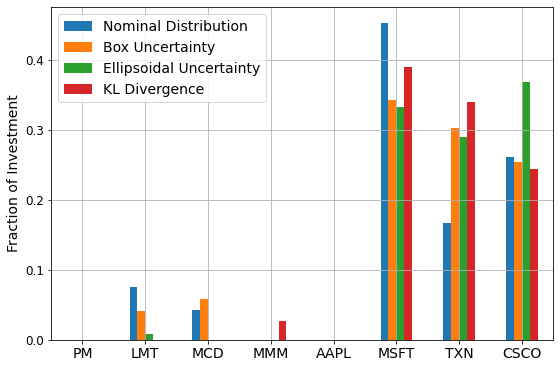

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(9, 6))
results = pd.DataFrame({'Nominal Distribution': x_nom,
                        'Box Uncertainty': x_box,
                        'Ellipsoidal Uncertainty': x_ellip,
                        'KL Divergence': x_kld})

results.plot(kind='bar', ax=axes)
axes.set_xticks(range(n), data.columns, rotation=0)
plt.legend(loc='upper left', fontsize=14)
plt.ylabel('Fraction of Investment', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

In this case study, the stock return rates for each sample record are deterministically set as $\pmb{r}_k$, without incorporating any uncertainty. As suggested by {cite:ps}`Bertsimas_Shtern_Surt2022two`, these fixed return outcomes can alternatively be modeled as random variables, subject to user-specified supports. This approach will be elucidated using the RSOME `dro` module for addressing distributionally robust optimization problems.

<br>

---

<font size="5">Reference</font>

```{bibliography}
:filter: docname in docnames
```